In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
class Mobitrack:
    # contructor for initialize fields
    def __init__(self):
        
        # variable initialization
        self.rawData = np.empty((0,7)) # time, ax, ay, az, gx, gy, gz
        self.smoothData = np.empty((0,7)) # time, ax, ay, az, gx, gy, gz
        self.data = np.empty((0,3)) # time, pitch, roll
        self.numSamplesSeen = 0
        
        # storage variables
        self.rawDataStorageWindowSize = 60 * 60 * 100 # store 60 minutes of data @ 100 Hz
        self.dataStorageWindowSize = 60 * 60 * 100 # store 60 minutes of data @ 100 Hz
        self.eventStorageWindowSize = 60 * 60 * 100
        
        # calibration
        self.calibrationG = 9.81
        self.calibrationAsens = 1
        self.calibrationGsens = 1
        
        # preprocessing
        self.smoothWindowSize = 50 # window size for moving average filter
        self.complementaryFilterAlpha = 0.1
        
        # peak detection
        self.last_pk = -1
        self.peaks = np.empty(0,dtype=int)
        self.valleys = np.empty(0,dtype=int)
        self.segments = np.empty(0,dtype=int)
        self.reps = np.empty(0,dtype=int)
        
        # segmentation
        self.segmentWindow = 100
        self.segmentMinPkDist = 50
        self.segmentPkThr = 0.5
        self.segmentMaxPk2PkDist = 20000
        
        # rep detection
        self.minROM = 40
        
    def processStep(self, data):
        # validate data
        if(len(data) != 7):
            print("Invalid data!")
            return
        
        # calibrate data
        if self.numSamplesSeen >= self.rawDataStorageWindowSize:
            self.rawData = self.rawData[1:]
        self.rawData = np.vstack((self.rawData, self.calibrateData(data)))
        
        # smooth data
        if self.numSamplesSeen >= self.rawDataStorageWindowSize:
            self.smoothData = self.smoothData[1:]
        self.smoothData = np.vstack((self.smoothData, self.preprocessData()))
        
        # compute angles
        if self.numSamplesSeen >= self.dataStorageWindowSize:
            self.data = self.data[1:]
        self.data = np.vstack((self.data, self.computeRotationAngles()))
        
        # peak detection
        isPeak = self.detectPeaks()
        
        if isPeak == 1:
            if len(self.peaks) == self.eventStorageWindowSize:
                self.peaks = np.copy(self.peaks[1:])
            self.peaks = np.append(self.peaks, self.numSamplesSeen - np.round(self.segmentWindow/2).astype(int))
            self.last_pk = self.numSamplesSeen - np.round(self.segmentWindow/2).astype(int)
        elif isPeak == -1:
            if len(self.valleys) == self.eventStorageWindowSize:
                self.valleys = np.copy(self.valleys[1:])
            self.valleys = np.append(self.valleys, self.numSamplesSeen - np.round(self.segmentWindow/2).astype(int))
            self.last_pk = self.numSamplesSeen - np.round(self.segmentWindow/2).astype(int)
        
        # detect segments
        isSegment = -1
        if isPeak != 0: isSegment = self.detectSegment()
        if isSegment != -1:
            if len(self.segments) == self.eventStorageWindowSize:
                self.segments = np.copy(self.segments[1:])
            self.segments = np.append(self.segments, isSegment)
        
        # detect segments
        isRep = -1
        if isSegment != -1: isRep = self.detectRepetition()
        if isRep != -1:
            if len(self.reps) == self.eventStorageWindowSize:
                self.reps = np.copy(self.reps[1:])
            self.reps = np.append(self.reps, isRep)
            print("idx:", isRep, " - Repetition Detected!")
        
        # increment numSamplesSeen
        self.numSamplesSeen += 1
    
    def calibrateData(self, data):
        # calibrate data by dividing by sensitivity
        data[1:4] = data[1:4] / self.calibrationAsens * self.calibrationG
        data[4:7] = data[4:7] / self.calibrationGsens
        return data
    
    def preprocessData(self):
        # smooth data with a moving average for specified window size
        smoothData = np.copy(self.rawData[-1,:])
            
        startSumIdx = 0
        if self.numSamplesSeen >= self.smoothWindowSize:
            startSumIdx = -self.smoothWindowSize
        
        for i in range(1,7):
            smoothData[i] = np.mean(self.rawData[startSumIdx:,i])
        return smoothData
    
    def computeRotationAngles(self):
        # compute pitch and roll using complementary filter
        
        # initialize variables
        data = self.smoothData[-1,:]
        angle_est = np.zeros(3)
        angle_est[0] = data[0]
        
        # estimate pitch and roll based on acceleration
        pitch_est_acc = np.rad2deg(np.arctan2(data[2], np.sqrt(data[1]**2 + data[3]**2))) # range [-90, 90]
        roll_est_acc = np.rad2deg(np.arctan2(data[1], np.sqrt(data[2]**2 + data[3]**2))) # range [-90, 90]
        
        # use acceleration data only for first sample
        if(self.numSamplesSeen == 0):
            angle_est[1] = pitch_est_acc
            angle_est[2] = roll_est_acc
        # use complementary filter otherwise
        else:
            # estimate pitch and roll based on gyroscope
            dt = self.smoothData[-1,0] - self.smoothData[-2,0]
            pitch_est_gyr = self.data[-1,1] + dt * data[4]
            roll_est_gyr = self.data[-1,2] + dt * data[5]
            
            # complementary filter
            angle_est[1] = (1-self.complementaryFilterAlpha) * pitch_est_gyr + self.complementaryFilterAlpha * pitch_est_acc
            angle_est[2] = (1-self.complementaryFilterAlpha) * roll_est_gyr + self.complementaryFilterAlpha * roll_est_acc
        
        return angle_est
    
    def detectPeaks(self):
        # peak detection, returns 1 if peak, -1 if valley, and 0 otherwise
        
        # check if enough samples
        if self.numSamplesSeen < self.segmentWindow: return 0
        
        # find center point
        pitch = self.data[-self.segmentWindow:,1]
        center_idx = self.numSamplesSeen - np.round(self.segmentWindow/2).astype(int)
        center = pitch[np.round(self.segmentWindow/2).astype(int)]
        
        # check for min dist
        if (self.last_pk == -1) or (center_idx - self.last_pk) >= self.segmentMinPkDist:
            # check if max or min
            if center == np.max(pitch) and (center - np.min(pitch)) >= self.segmentPkThr:
                return 1
            elif center == np.min(pitch) and (np.max(pitch) - center) >= self.segmentPkThr:
                return -1
        return 0
    
    def detectSegment(self):
        # segment detection, returns index if segment found, -1 otherwise
        if len(self.peaks) >= 2 and len(self.valleys) >= 1:
            if self.numSamplesSeen - np.round(self.segmentWindow/2).astype(int) == self.peaks[-1]:
                if self.peaks[-1] > self.valleys[-1] and self.valleys[-1] > self.peaks[-2]:
                    if (self.peaks[-1] - self.peaks[-2]) <= self.segmentMaxPk2PkDist:
                        return self.peaks[-1]
        return -1
    
    def detectRepetition(self):
        # repetition detection, returns index if rep found, -1 otherwise
        if len(self.peaks) >= 2 and len(self.valleys) >= 1:
            if self.numSamplesSeen - np.round(self.segmentWindow/2).astype(int) == self.peaks[-1]:
                ROM_f = self.data[self.peaks[-1],1] - self.data[self.valleys[-1],1]
                ROM_b = self.data[self.peaks[-2],1] - self.data[self.valleys[-1],1]
                print("ROM:", round(min(ROM_f, ROM_b), 2))
                if min(ROM_f, ROM_b) >= self.minROM:
                    return self.peaks[-1]
        return -1
    
    def plotData(self):
        plt.figure(figsize=(20,10))
        
        plt.plot(self.data[:,0], self.data[:,1] , label='Pitch')
#         plt.plot(self.data[:,0], self.data[:,2], label='Roll')
        
        plt.plot(self.data[self.peaks,0], self.data[self.peaks,1], 'yx', label='Peaks')
        plt.plot(self.data[self.valleys,0], self.data[self.valleys,1], 'mx', label='Valleys')
        plt.plot(self.data[self.reps,0], self.data[self.reps,1], 'g.', label='Reps')
        
        plt.xlabel('Time (s)')
        plt.ylabel('Angle')
        plt.legend()
        
        plt.savefig(f.replace('.txt', '.png'))
        
        plt.show()

    def plotRawData(self):
        plt.figure(figsize=(20,10))
        
        plt.plot(self.rawData[:,0], self.rawData[:,1], label='ax')
        plt.plot(self.rawData[:,0], self.rawData[:,2], label='ay')
        plt.plot(self.rawData[:,0], self.rawData[:,3], label='az')
        plt.plot(self.rawData[:,0], self.rawData[:,4], label='gx')
        plt.plot(self.rawData[:,0], self.rawData[:,5], label='gy')
        plt.plot(self.rawData[:,0], self.rawData[:,6], label='gz')
        
        plt.xlabel('Time (s)')
        plt.ylabel('Raw IMU Readings (a in m/s^2, g in rad/s)')
        plt.legend()
        
        plt.savefig(f.replace('.txt', '_raw.png'))
        
        plt.show()
        
    def plotSmoothData(self):
        plt.figure(figsize=(20,10))
        plt.plot(self.smoothData[:,0], self.smoothData[:,1], label='ax')
        plt.plot(self.smoothData[:,0], self.smoothData[:,2], label='ay')
        plt.plot(self.smoothData[:,0], self.smoothData[:,3], label='az')
        plt.plot(self.smoothData[:,0], self.smoothData[:,4], label='gx')
        plt.plot(self.smoothData[:,0], self.smoothData[:,5], label='gy')
        plt.plot(self.smoothData[:,0], self.smoothData[:,6], label='gz')
        
        plt.xlabel('Time (s)')
        plt.ylabel('Smoothed IMU Readings (a in m/s^2, g in rad/s)')
        plt.legend()
        
        plt.savefig(f.replace('.txt', '_smooth.png'))
        
        plt.show()
        
    def clear(self):
        # variable initialization
        self.rawData = np.empty((0,7)) # time, ax, ay, az, gx, gy, gz
        self.smoothData = np.empty((0,7)) # time, ax, ay, az, gx, gy, gz
        self.data = np.empty((0,3)) # time, pitch, roll
        self.numSamplesSeen = 0
        
        # peak detection
        self.last_pk = -1
        self.peaks = np.empty(0,dtype=int)
        self.valleys = np.empty(0,dtype=int)
        self.segments = np.empty(0,dtype=int)
        self.reps = np.empty(0,dtype=int)

['/home/jason/Downloads/Jan25_AndreaSOP_Left/data_forearm_25.txt', '/home/jason/Downloads/Jan25_AndreaSOP_Left/data_forearm_lying_full.txt', '/home/jason/Downloads/Jan25_AndreaSOP_Left/data_wrist_full.txt', '/home/jason/Downloads/Jan25_AndreaSOP_Left/data_ankle_full.txt', '/home/jason/Downloads/Jan25_AndreaSOP_Left/data_forearm_full.txt', '/home/jason/Downloads/Jan25_AndreaSOP_Left/data_shank_25.txt', '/home/jason/Downloads/Jan25_AndreaSOP_Left/data_wrist_25.txt', '/home/jason/Downloads/Jan25_AndreaSOP_Left/data_shank_35.txt', '/home/jason/Downloads/Jan25_AndreaSOP_Left/data_ankle_35.txt', '/home/jason/Downloads/Jan25_AndreaSOP_Left/data_forearm_lying_35.txt', '/home/jason/Downloads/Jan25_AndreaSOP_Left/data_ankle_25.txt', '/home/jason/Downloads/Jan25_AndreaSOP_Left/data_forearm_35.txt', '/home/jason/Downloads/Jan25_AndreaSOP_Left/data_forearm_lying_25.txt', '/home/jason/Downloads/Jan25_AndreaSOP_Left/data_wrist_35.txt', '/home/jason/Downloads/Jan25_AndreaSOP_Left/data_shank_full.txt']

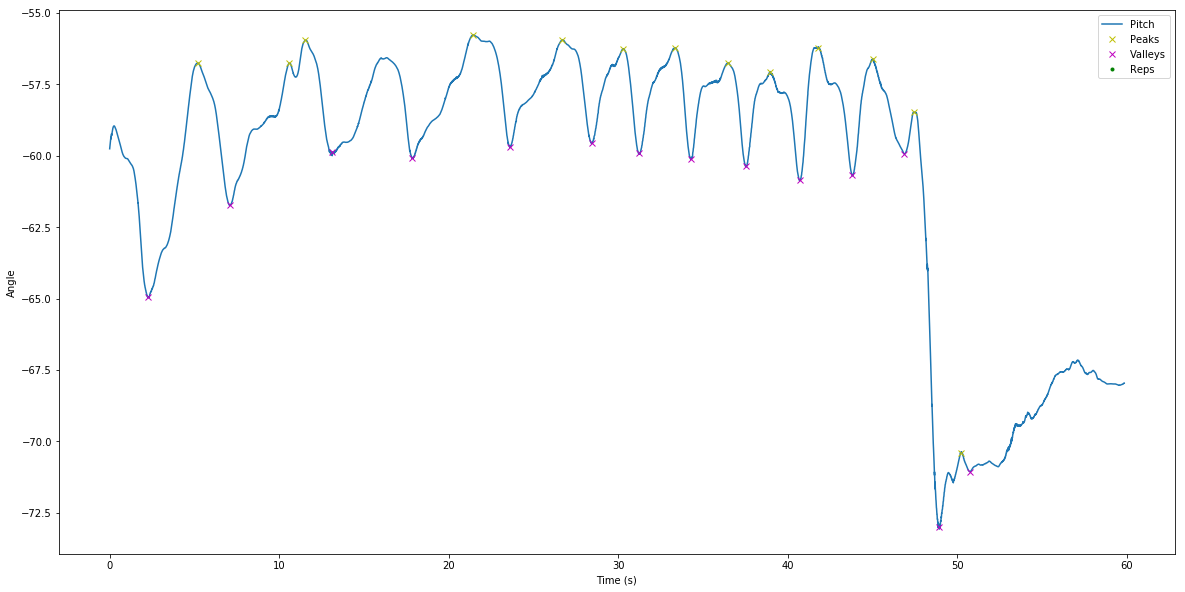

/home/jason/Downloads/Jan25_AndreaSOP_Left/data_forearm_lying_full.txt
ROM: 52.63
idx: 701  - Repetition Detected!
ROM: 51.82
idx: 1300  - Repetition Detected!
ROM: 51.12
idx: 2006  - Repetition Detected!
ROM: 57.18
idx: 2525  - Repetition Detected!
ROM: 1.62
ROM: 2.78
ROM: 58.97
idx: 3468  - Repetition Detected!
ROM: 61.91
idx: 3810  - Repetition Detected!
ROM: 60.98
idx: 4150  - Repetition Detected!
ROM: 64.6
idx: 4524  - Repetition Detected!
ROM: 64.0
idx: 4860  - Repetition Detected!
ROM: 64.64
idx: 5173  - Repetition Detected!
ROM: 63.45
idx: 5428  - Repetition Detected!
ROM: 67.31
idx: 5651  - Repetition Detected!
ROM: 69.17
idx: 5865  - Repetition Detected!
ROM: 70.73
idx: 6110  - Repetition Detected!


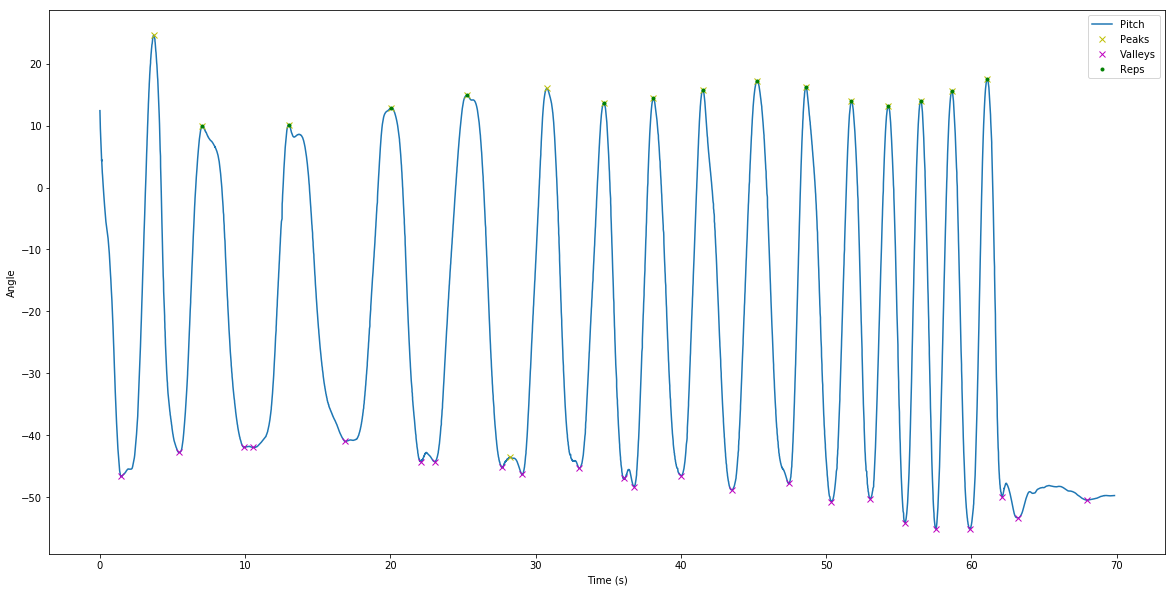

/home/jason/Downloads/Jan25_AndreaSOP_Left/data_wrist_full.txt
ROM: 30.89
ROM: 37.97
ROM: 33.54
ROM: 30.89
ROM: 1.1
ROM: 1.8
ROM: 39.6
ROM: 38.53
ROM: 34.88
ROM: 32.9
ROM: 33.28
ROM: 42.7
idx: 4468  - Repetition Detected!
ROM: 35.36
ROM: 38.93
ROM: 35.95
ROM: 34.72


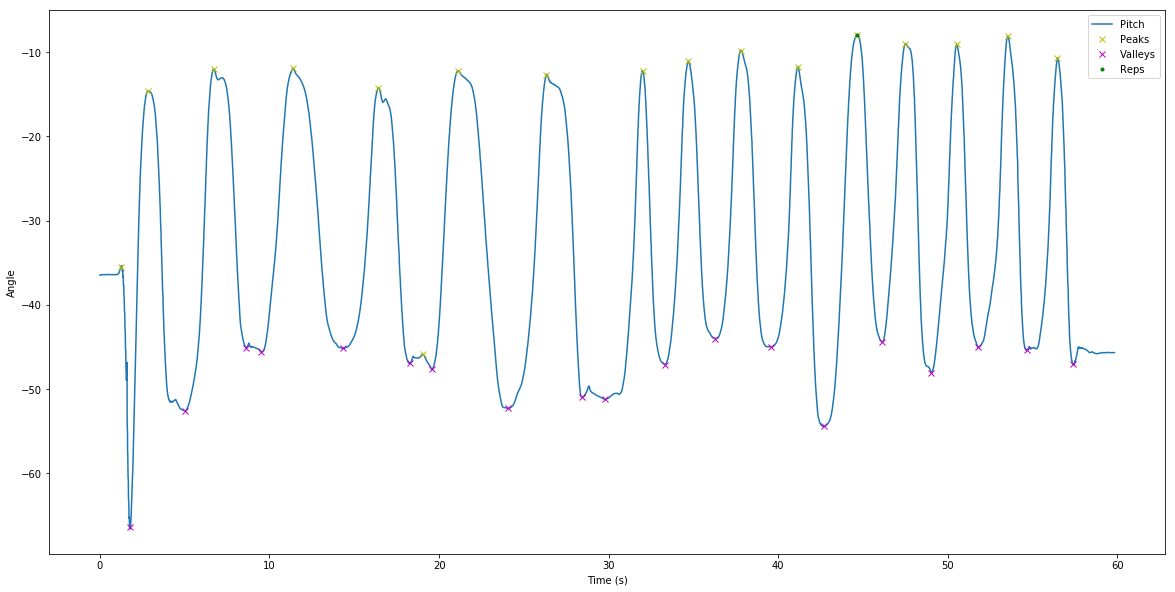

/home/jason/Downloads/Jan25_AndreaSOP_Left/data_ankle_full.txt
ROM: 47.49
idx: 733  - Repetition Detected!
ROM: 50.76
idx: 1300  - Repetition Detected!
ROM: 49.34
idx: 1868  - Repetition Detected!
ROM: 52.11
idx: 2500  - Repetition Detected!
ROM: 50.94
idx: 3155  - Repetition Detected!
ROM: 43.28
idx: 3669  - Repetition Detected!
ROM: 44.09
idx: 4006  - Repetition Detected!
ROM: 46.94
idx: 4378  - Repetition Detected!
ROM: 47.07
idx: 4759  - Repetition Detected!
ROM: 47.33
idx: 5107  - Repetition Detected!
ROM: 46.14
idx: 5482  - Repetition Detected!


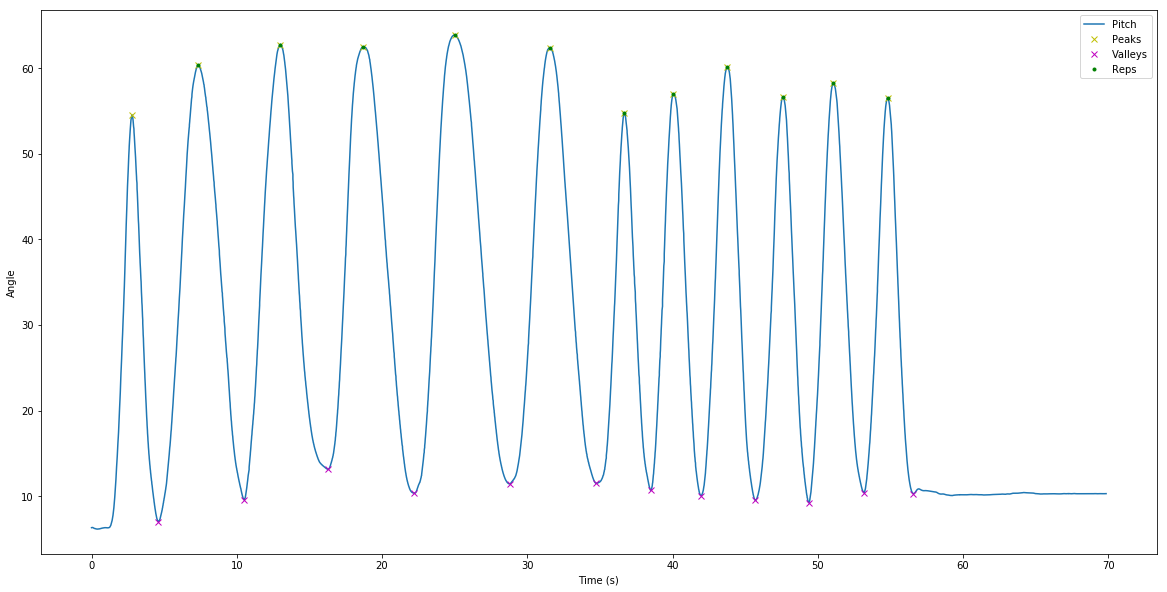

/home/jason/Downloads/Jan25_AndreaSOP_Left/data_forearm_full.txt
ROM: 3.4
ROM: 17.23
ROM: 23.24
ROM: 23.16
ROM: 1.52
ROM: 25.98
ROM: 24.03
ROM: 20.81
ROM: 23.36
ROM: 24.62
ROM: 25.41
ROM: 25.34
ROM: 24.46
ROM: 9.26


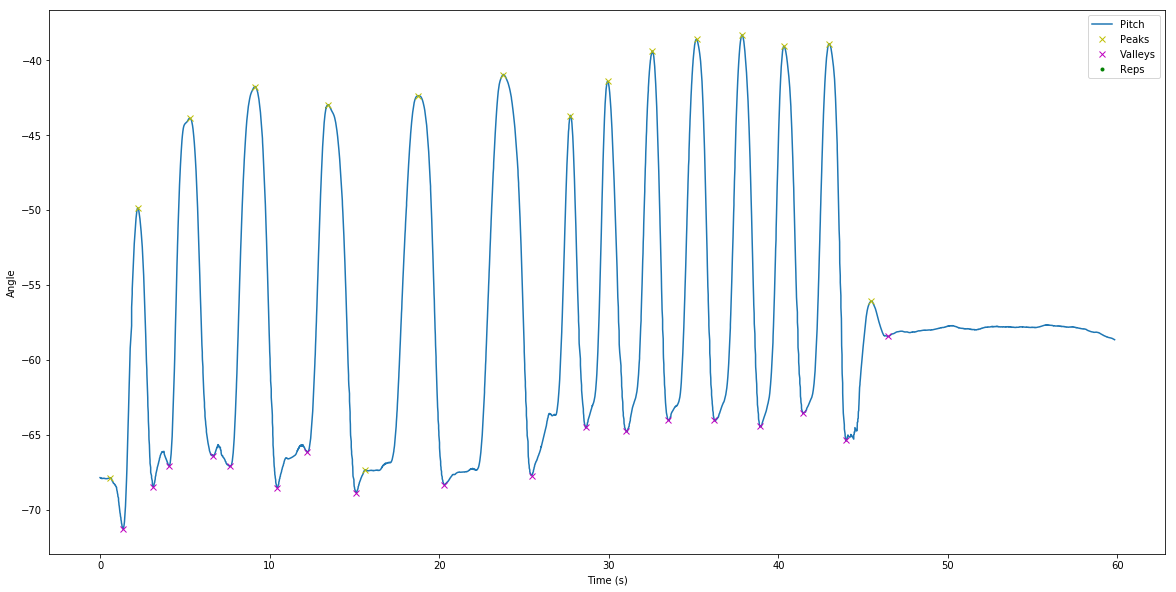

/home/jason/Downloads/Jan25_AndreaSOP_Left/data_shank_25.txt
ROM: 1.62
ROM: 2.0
ROM: 18.37
ROM: 21.75
ROM: 21.05
ROM: 25.7
ROM: 23.63
ROM: 25.96
ROM: 23.69
ROM: 24.12
ROM: 23.81
ROM: 20.32
ROM: 19.57
ROM: 21.65
ROM: 21.54
ROM: 21.47


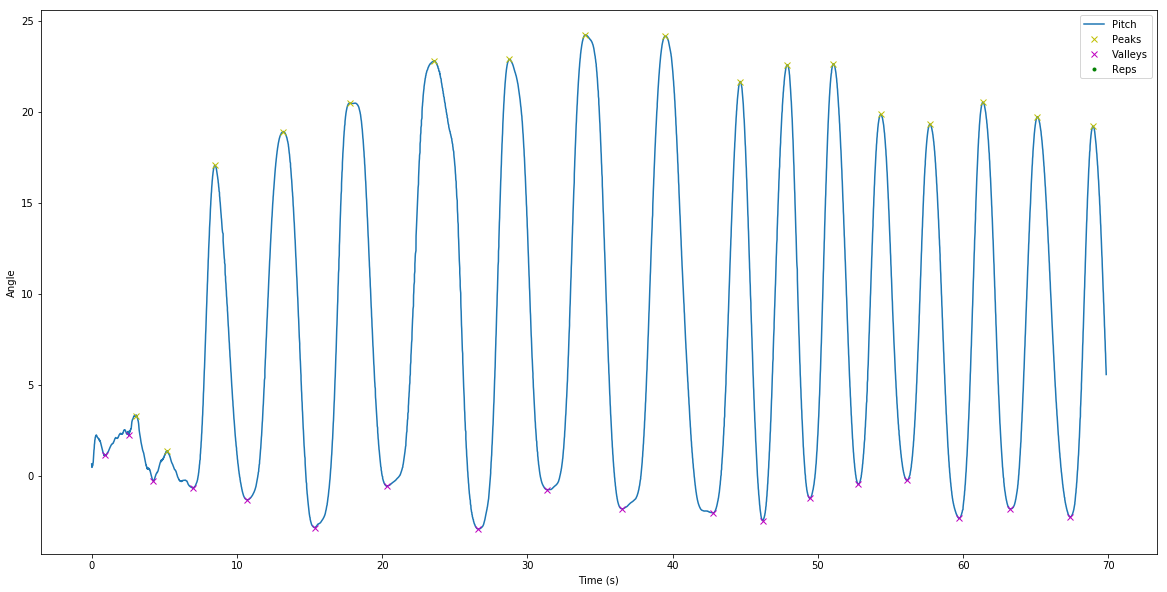

/home/jason/Downloads/Jan25_AndreaSOP_Left/data_wrist_25.txt
ROM: 20.1
ROM: 19.9
ROM: 18.6
ROM: 18.68
ROM: 19.01
ROM: 22.52
ROM: 22.05
ROM: 20.86
ROM: 21.22
ROM: 21.35
ROM: 20.86
ROM: 0.56
ROM: 8.19
ROM: 1.73


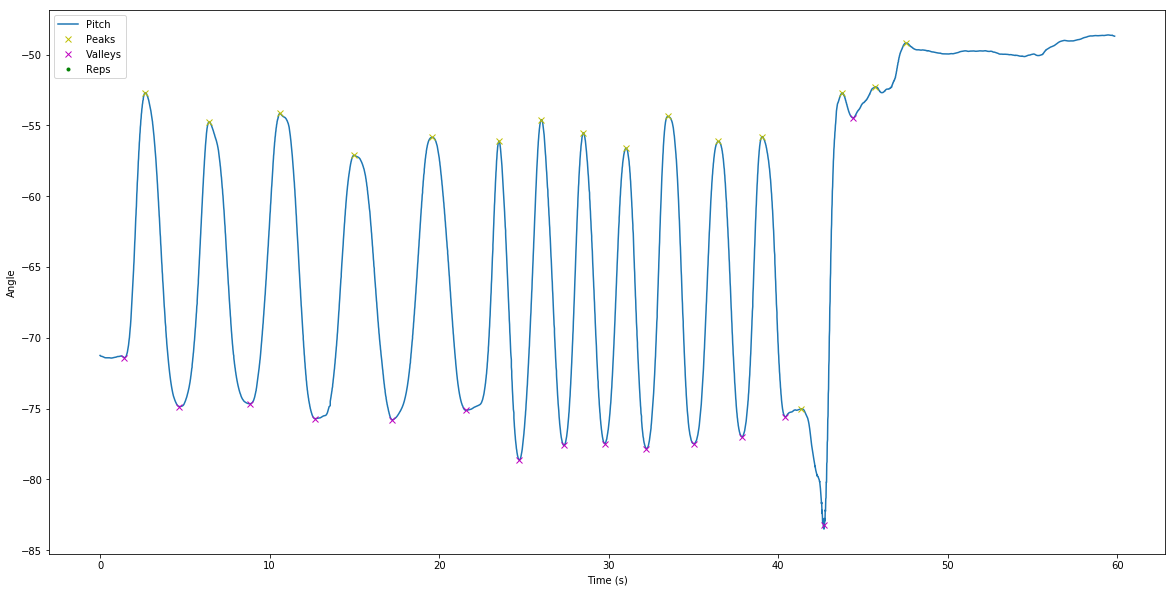

/home/jason/Downloads/Jan25_AndreaSOP_Left/data_shank_35.txt
ROM: 35.76
ROM: 33.41
ROM: 37.03
ROM: 34.58
ROM: 37.46
ROM: 32.61
ROM: 32.53
ROM: 27.38
ROM: 27.15
ROM: 29.15
ROM: 33.97
ROM: 31.6
ROM: 0.67


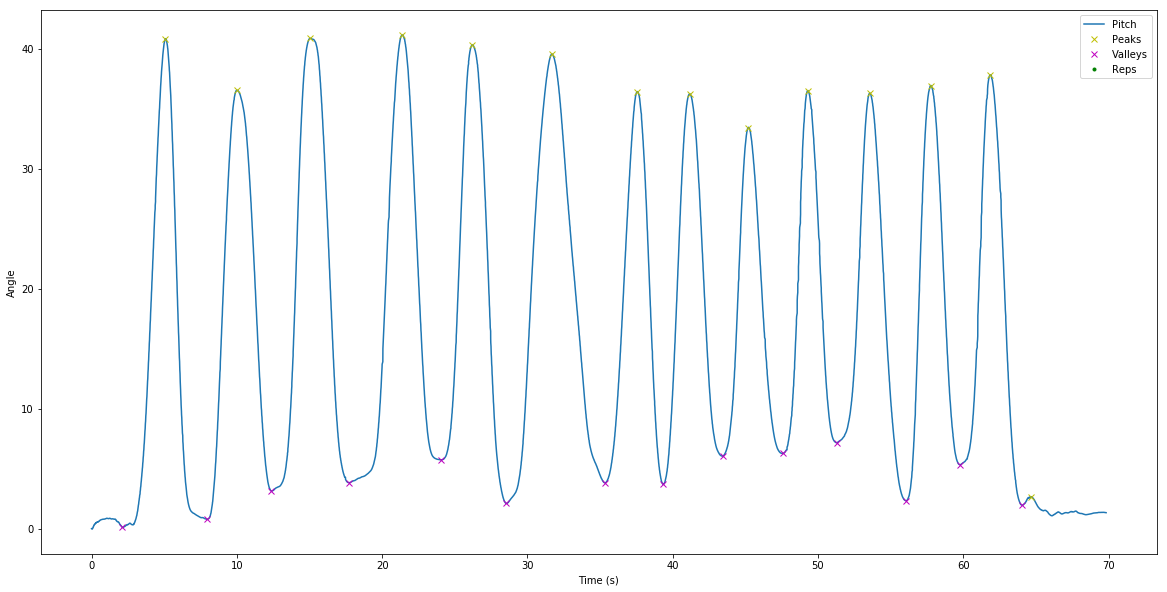

/home/jason/Downloads/Jan25_AndreaSOP_Left/data_ankle_35.txt
ROM: 36.84
ROM: 36.03
ROM: 33.09
ROM: 34.43
ROM: 30.3
ROM: 29.1
ROM: 32.77
ROM: 33.15
ROM: 33.98
ROM: 33.02


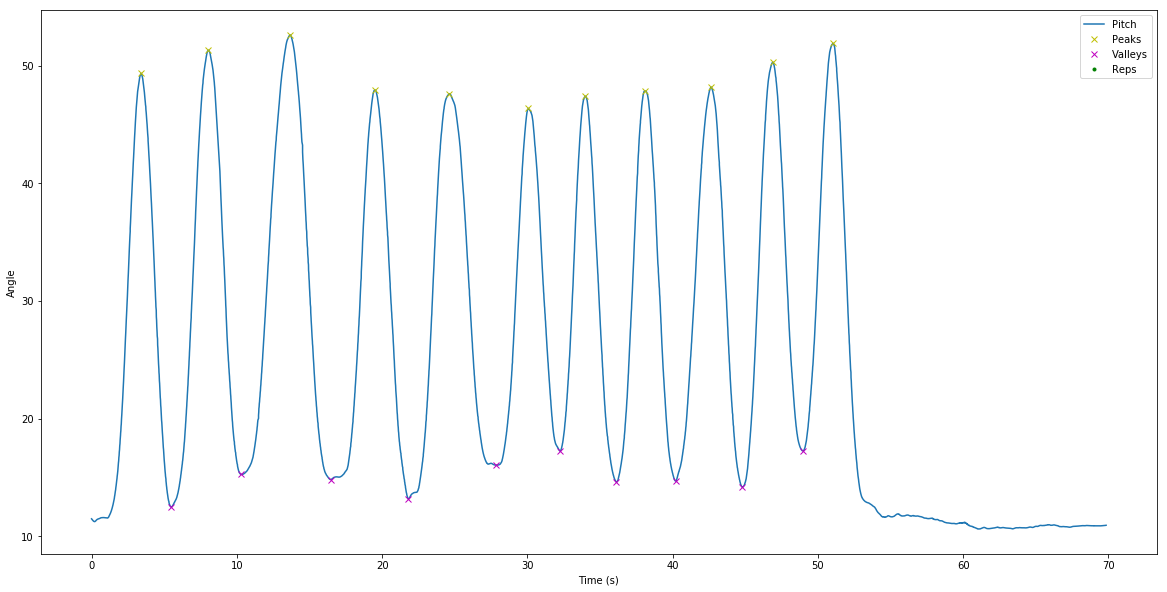

/home/jason/Downloads/Jan25_AndreaSOP_Left/data_forearm_lying_35.txt
ROM: 1.55
ROM: 24.19
ROM: 17.13
ROM: 17.07
ROM: 15.18
ROM: 15.61
ROM: 21.42
ROM: 15.59
ROM: 14.36
ROM: 16.38
ROM: 14.51
ROM: 11.2
ROM: 13.09
ROM: 11.39
ROM: 12.34
ROM: 10.99
ROM: 13.86
ROM: 13.45
ROM: 4.6


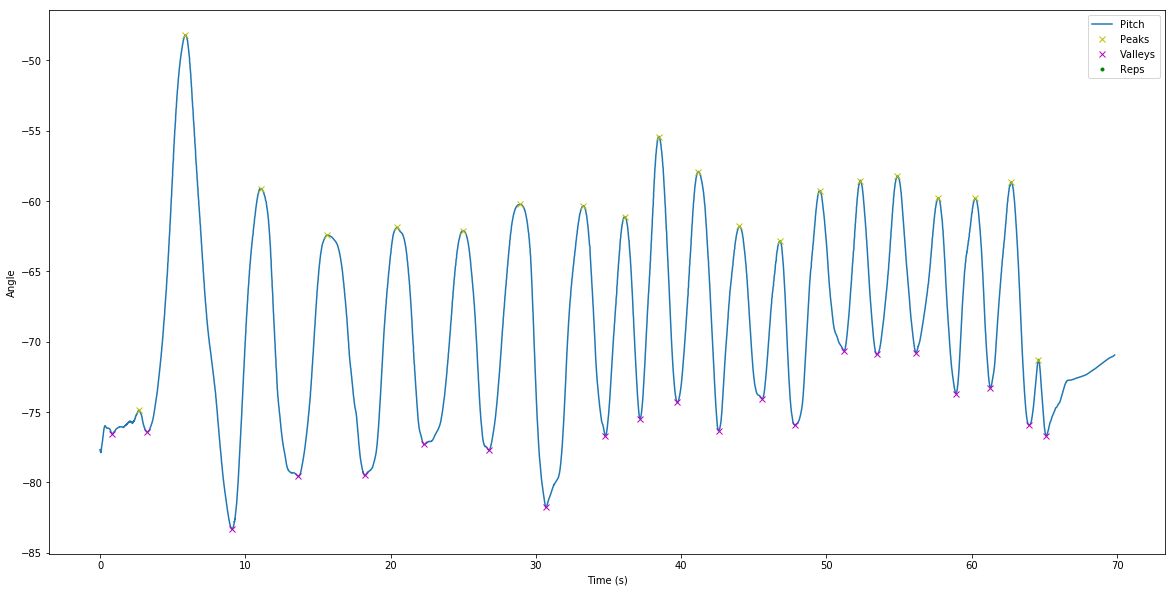

/home/jason/Downloads/Jan25_AndreaSOP_Left/data_ankle_25.txt
ROM: 27.76
ROM: 24.64
ROM: 28.68
ROM: 27.91
ROM: 30.34
ROM: 25.51
ROM: 24.14
ROM: 23.76
ROM: 26.93
ROM: 26.64
ROM: 29.11
ROM: 1.92


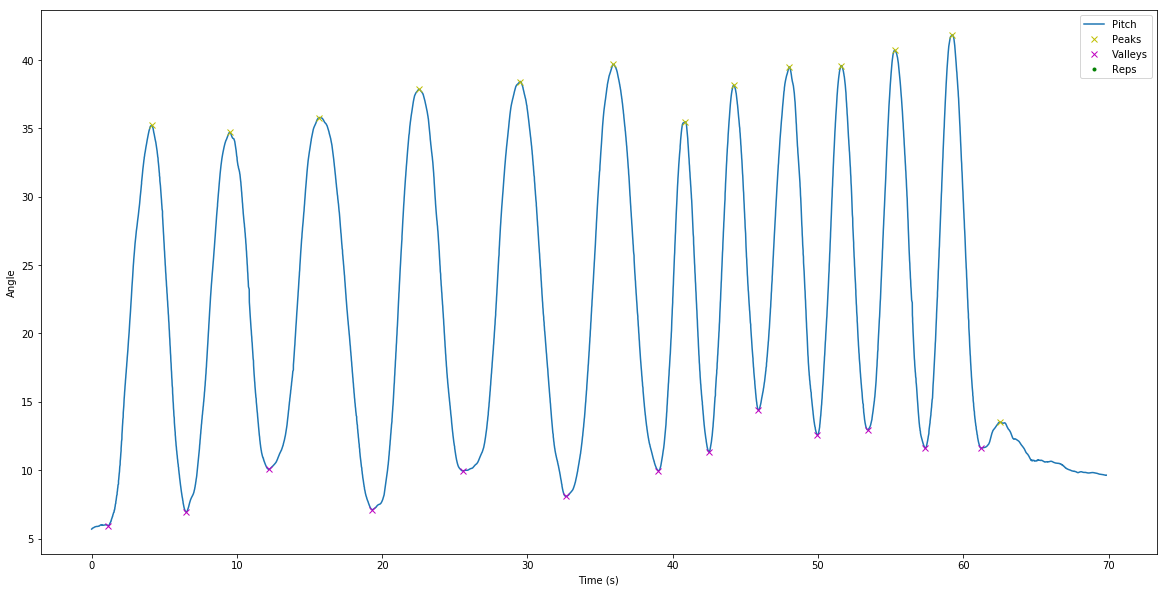

/home/jason/Downloads/Jan25_AndreaSOP_Left/data_forearm_35.txt
ROM: 6.8
ROM: 6.58
ROM: 6.87
ROM: 7.44
ROM: 5.89
ROM: 3.56
ROM: 0.54
ROM: 4.02
ROM: 0.57
ROM: 2.79
ROM: 1.02
ROM: 3.56
ROM: 1.07
ROM: 3.33
ROM: 3.05


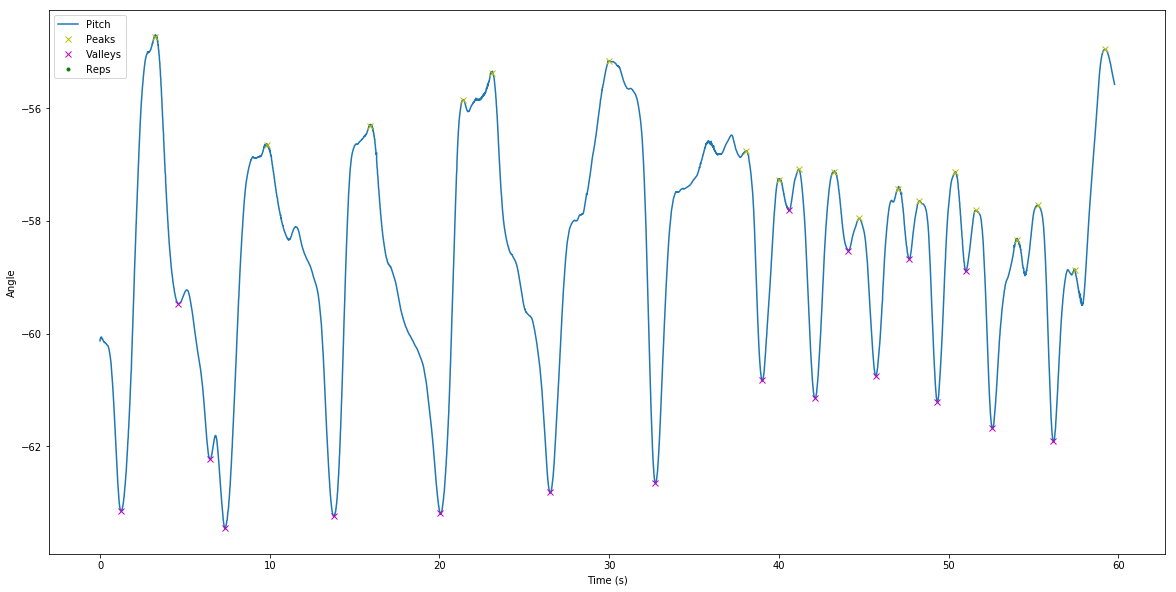

/home/jason/Downloads/Jan25_AndreaSOP_Left/data_forearm_lying_25.txt
ROM: 14.78
ROM: 13.56
ROM: 10.8
ROM: 8.7
ROM: 5.87
ROM: 7.3
ROM: 7.52
ROM: 8.05
ROM: 5.21
ROM: 3.47
ROM: 3.95
ROM: 4.87
ROM: 5.18
ROM: 7.76
ROM: 5.84
ROM: 8.39


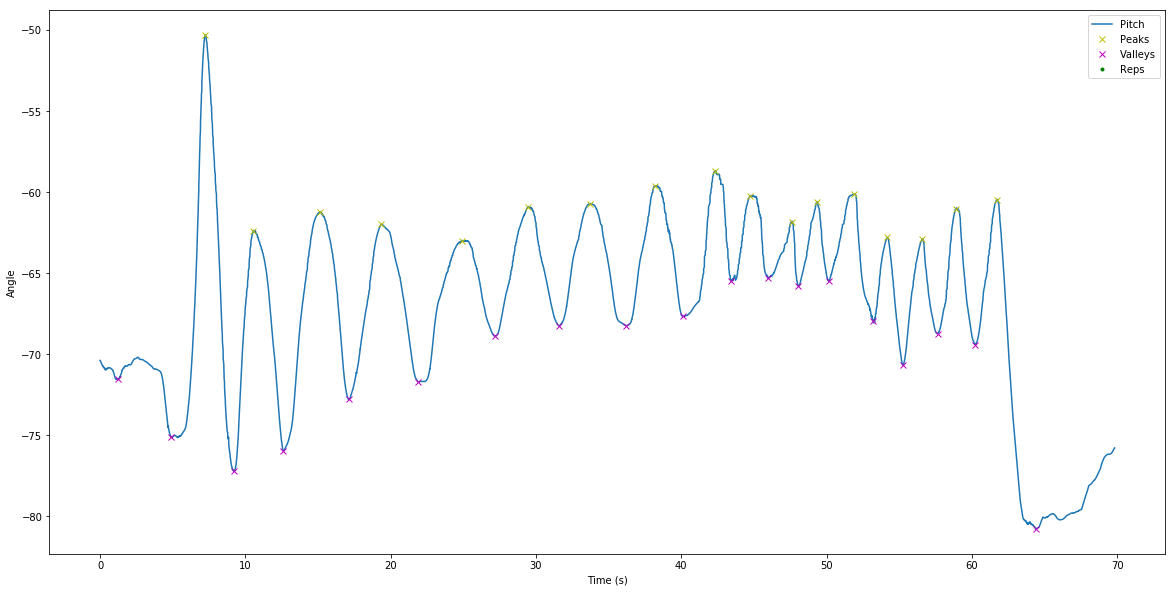

/home/jason/Downloads/Jan25_AndreaSOP_Left/data_wrist_35.txt
ROM: 8.22
ROM: 12.43
ROM: 15.51
ROM: 15.54
ROM: 13.9
ROM: 14.25
ROM: 14.08
ROM: 14.67


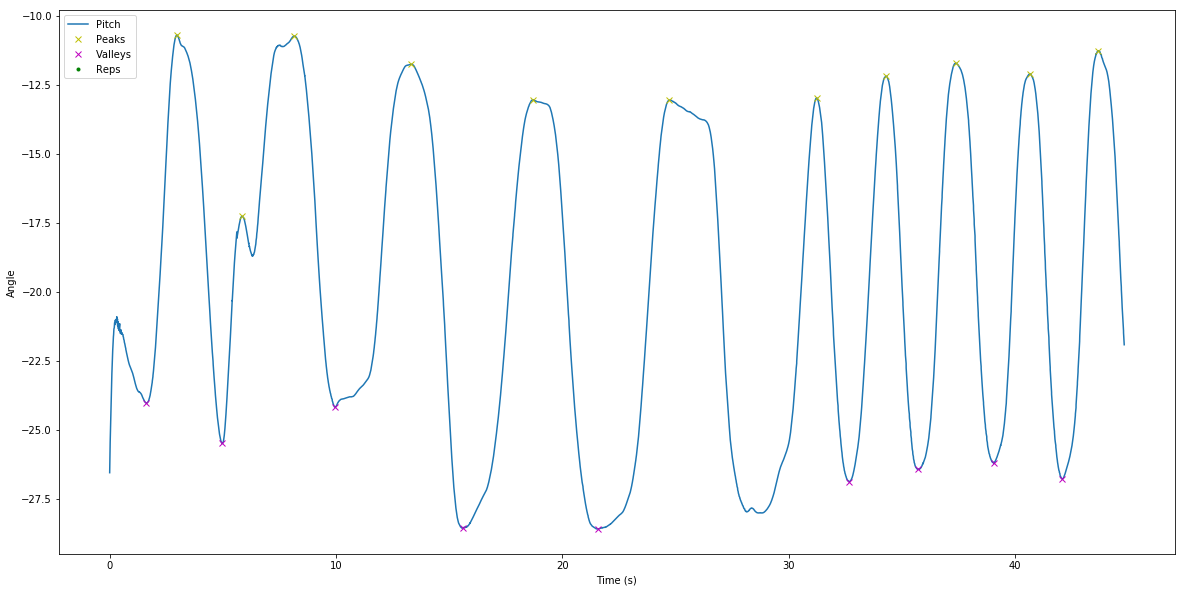

/home/jason/Downloads/Jan25_AndreaSOP_Left/data_shank_full.txt
ROM: 50.39
idx: 1280  - Repetition Detected!
ROM: 45.2
idx: 1779  - Repetition Detected!
ROM: 45.08
idx: 2366  - Repetition Detected!
ROM: 47.99
idx: 2935  - Repetition Detected!
ROM: 46.07
idx: 3585  - Repetition Detected!
ROM: 42.93
idx: 4141  - Repetition Detected!
ROM: 46.07
idx: 4494  - Repetition Detected!
ROM: 44.19
idx: 4877  - Repetition Detected!
ROM: 41.35
idx: 5277  - Repetition Detected!
ROM: 46.09
idx: 5664  - Repetition Detected!
ROM: 45.4
idx: 6017  - Repetition Detected!
ROM: 45.95
idx: 6392  - Repetition Detected!
ROM: 46.45
idx: 6761  - Repetition Detected!


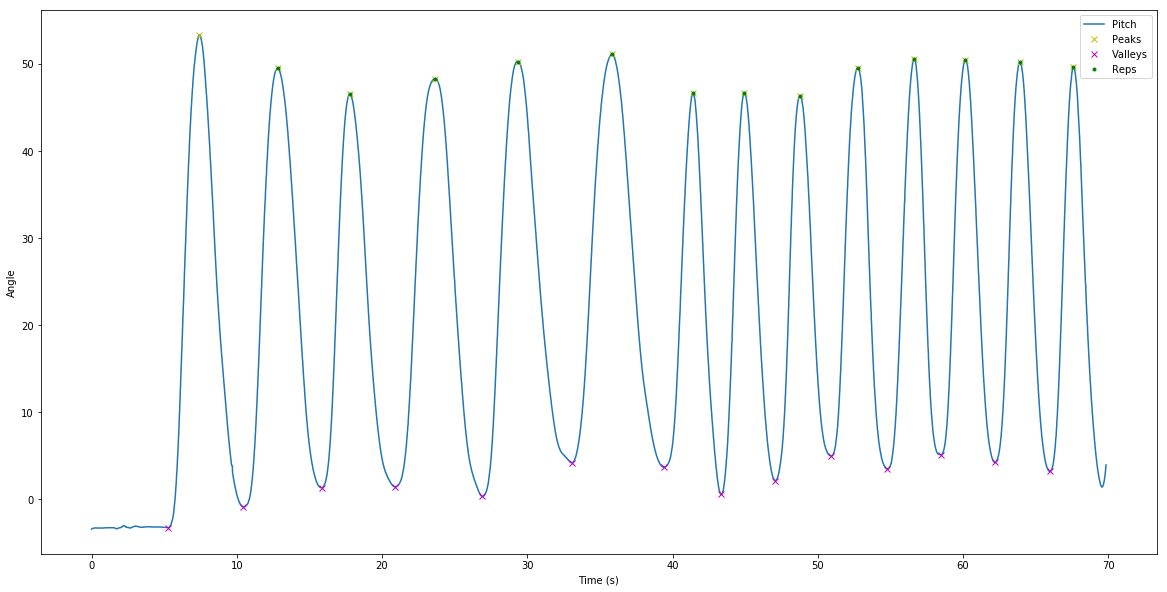

In [3]:
import os

m = Mobitrack()

data_dir = '/home/jason/Downloads/Jan25_AndreaSOP_Left'
files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f)) and f.endswith('.txt')]
print(files)

for f in files:
    data = pd.read_csv(f).values
    data[:,0] = (data[:,0] - data[0,0]) / 1000
    
    print(f)
    for i in range(data.shape[0]):
        m.processStep(data[i,:])
    
    m.plotData()
#     m.plotRawData()
#     m.plotSmoothData()
    m.clear()